# Part 2 - Aim: Practice the usage of CNN  - oxford 102 flowers
## Result summary (Accuracy)

### SqueezeNet
1st run - 73.4%

2nd run - 78.6%

### MobileNetV3
1st run - 73.09%

2nd run - 74.46%

In [ ]:
import pickle
import os
import pandas as pd
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras import layers
from tensorflow import keras


The following model is a pretrained model called SqueezNnet
The original model was modified to accept 102 features as output (102 flowers dataset)
All pretrain layers were set to non-trainable

In [9]:
def squeezenet(include_softmax=True):
    with open(os.path.join("weights", "squeezenet_weights.pkl"), "rb") as f:
        weights = pickle.load(f)  # weights have been packed in dictionary
    classes = 1000

    def _fire(x_, filters, name="fire"):
        sq_filters, ex1_filters, ex2_filters = filters
        squeeze = layers.Conv2D(
            sq_filters, (1, 1), padding='same', name=name + "/squeeze1x1")(x_)
        squeeze = layers.ReLU()(squeeze)

        expand1 = layers.Conv2D(
            ex1_filters, (1, 1),
            padding='same', name=name + "/expand1x1")(squeeze)
        expand1 = layers.ReLU()(expand1)
        expand2 = layers.Conv2D(
            ex2_filters, (3, 3),
            padding='same', name=name + "/expand3x3")(squeeze)
        expand2 = layers.ReLU()(expand2)
        x_ = layers.Concatenate(axis=-1, name=name + "Concat")([expand1, expand2])

        return x_

    img_input = layers.Input(shape=(227, 227, 3))

    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", name='conv1')(img_input)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1')(x)

    x = _fire(x, (16, 64, 64), name="fire2")
    x = _fire(x, (16, 64, 64), name="fire3")

    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool3')(x)

    x = _fire(x, (32, 128, 128), name="fire4")
    x = _fire(x, (32, 128, 128), name="fire5")

    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool5')(x)

    x = _fire(x, (48, 192, 192), name="fire6")
    x = _fire(x, (48, 192, 192), name="fire7")

    x = _fire(x, (64, 256, 256), name="fire8")
    x = _fire(x, (64, 256, 256), name="fire9")

    x = layers.Conv2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Conv2D(102, (1, 1), padding='valid', name='final')(x)
    x = layers.AveragePooling2D(pool_size=(13, 13), name='avgpool10')(x)
    x = layers.Flatten(name='flatten10')(x)
    if include_softmax:
        x = layers.Softmax(name='softmax')(x)

    model = keras.Model([img_input], [x])

    for layer in model.layers:
        if layer.name in weights:
            layer.set_weights(weights[layer.name])
            layer.trainable = False

    opt = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

    return model

## Loading files
In the following code we read the images into an array
each image is converted to 3d array(227x227x3) - (width, height, color-RGB)
each item in the array consist with a value between 0 - 255 (RGB)
also each image go throw preprocess_input Keras function



In [6]:
def load_data():
    files = 8190
    y = pd.read_csv("labels.csv")['label'].values
    # Converting IDs (1-102) => (0-101) (python format)
    y = y - 1
    y = y[0: files - 1]

    X = []
    for i in range(1, files):
        path = f"jpg/image_{'{:05d}'.format(i)}.jpg"
        img = image.load_img(path, target_size=(227, 227))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        X.append(img[0])

    X = np.array(X)
    return X,y

## Splitting Training and Testing
 1. split the data into Train, Validation and Test
 2. Train the model with Train and Validation datasets
 3. Test the model

In [16]:
def train_test(X, y, model):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.5, random_state=123, stratify=y)

    X_val, X_test, y_val, y_test = train_test_split(
       X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)
    y_train = to_categorical(y_train, num_classes=102)
    y_val = to_categorical(y_val, num_classes=102)
    mon = 'val_accuracy'
    early_stop = EarlyStopping(monitor=mon, min_delta=0.0001, patience=5, restore_best_weights=True, mode='max')
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stop])
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy - {acc}")
    return history

### 1st Run

In [12]:
X, y = load_data()
model = squeezenet()
history = train_test(X, y, model)

Epoch 1/10


/usr/local/anaconda3/envs/autoKerasTest/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


128/128 [==============================] - 39s 301ms/step - loss: 8.2821 - accuracy: 0.2587 - val_loss: 3.2907 - val_accuracy: 0.5125

### Graphs

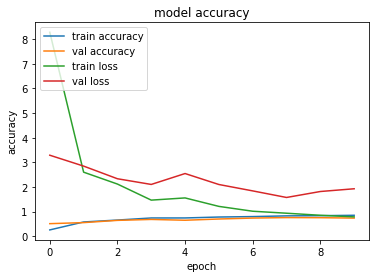

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy', 'train loss', 'val loss'], loc='upper left')
plt.show()

### 2nd Run

In [23]:
model = squeezenet()
history = train_test(X, y, model)

## VGG19 model

/usr/local/anaconda3/envs/autoKerasTest/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
128/128 [==============================] - 33s 245ms/step - loss: 7.9848 - accuracy: 0.2709 - val_loss: 4.0044 - val_accuracy: 0.4577

In [24]:
from keras.applications.mobilenet_v3 import  MobileNetV3Small
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
import tensorflow as tf
from tensorflow import keras


def mobile_net():
    # load model without classifier layers
    model = MobileNetV3Small(input_shape=(227, 227 ,3), include_top=False, weights='imagenet')
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    droupout = Dropout(0.5)(model.layers[-1].output)
    flat1 = Flatten()(droupout)
    output = Dense(102, activation='softmax')(flat1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)

    opt = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model

### 1st Run

In [25]:
model = mobile_net()
history = train_test(X, y, model)

/usr/local/anaconda3/envs/autoKerasTest/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
128/128 [==============================] - 32s 220ms/step - loss: 5.8475 - accuracy: 0.1827 - val_loss: 2.0116 - val_accuracy: 0.5349

### Graphs

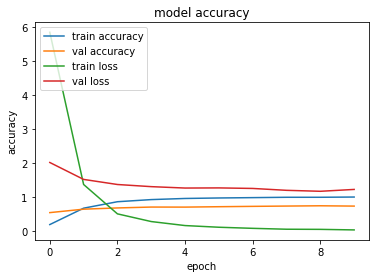

In [26]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy', 'train loss', 'val loss'], loc='upper left')
plt.show()

### 2nd Run

In [27]:
model = mobile_net()
history = train_test(X, y, model)

/usr/local/anaconda3/envs/autoKerasTest/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
128/128 [==============================] - 34s 235ms/step - loss: 5.9611 - accuracy: 0.1751 - val_loss: 2.0299 - val_accuracy: 0.5393

# Thanks